In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from itertools import compress
#import statsmodels.api as sm
from scipy import stats

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
train_data.drop(['Id'] , axis=1 , inplace = True)

In [3]:
train_data.shape

(1460, 80)

In [4]:
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Removing columns with lots of NAs

In [5]:

na_fields = ((train_data.isnull().sum() / train_data.shape[0]) > 0.05 ).sort_values(ascending = False) # Identifying columns where na values are more than 5%
train_data.drop(list(compress(na_fields.index.values, na_fields)) , axis = 1 ,inplace=True)

### Cleaning data

In [6]:
train_data['BsmtQual'].fillna("No" ,inplace = True)
train_data['MoSold'] = train_data['MoSold'].astype(str)
train_data['MSSubClass'] = train_data['MSSubClass'].astype(str)

### Segregate variables into cont and cat

In [7]:
desc = train_data.describe()
desc.drop('SalePrice' , axis = 1,inplace = True)
num_variables = list(desc.columns)
cat_variables = [x for x in train_data.columns if x not in num_variables and x != 'SalePrice']
y = train_data['SalePrice']

In [8]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

### Check for individual correlations for categorical variables

In [11]:
train_data_num = train_data[num_variables] 
cor_matrix = np.corrcoef(train_data_num.assign(SalePrice = y),rowvar=False)

pd.DataFrame({ 'variable': train_data_num.columns , 'corr': cor_matrix[:-1,-1] }).sort_values('corr' , ascending = False)


,variable,corr
1,OverallQual,0.790982
13,GrLivArea,0.708624
22,GarageCars,0.640409
23,GarageArea,0.623431
9,TotalBsmtSF,0.613581
10,1stFlrSF,0.605852
16,FullBath,0.560664
20,TotRmsAbvGrd,0.533723
3,YearBuilt,0.522897
4,YearRemodAdd,0.507101


C:\Users\nigamd\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


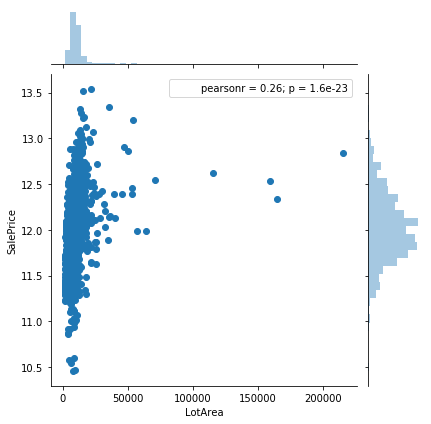

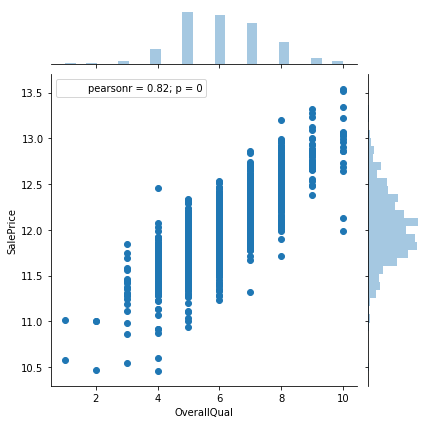

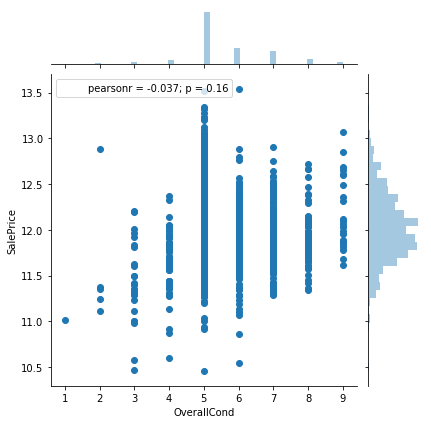

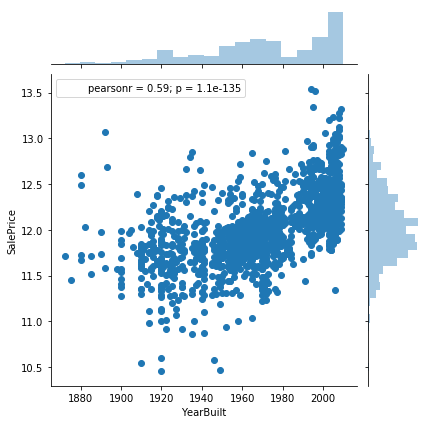

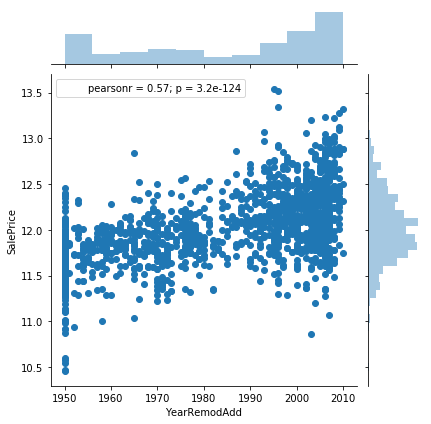

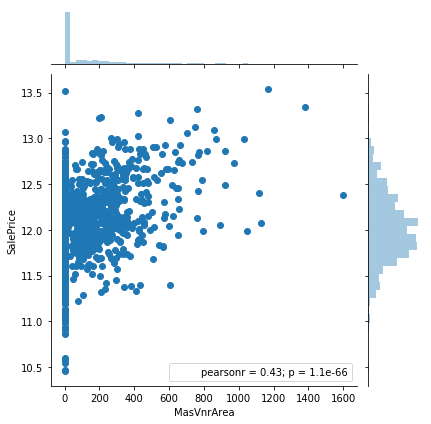

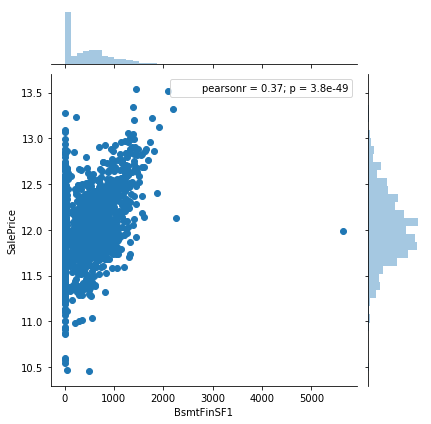

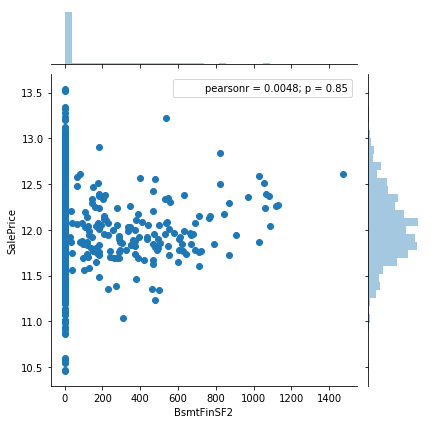

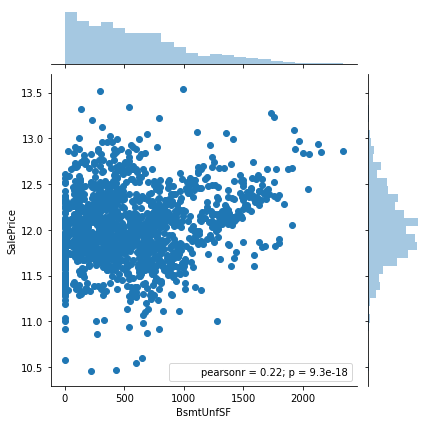

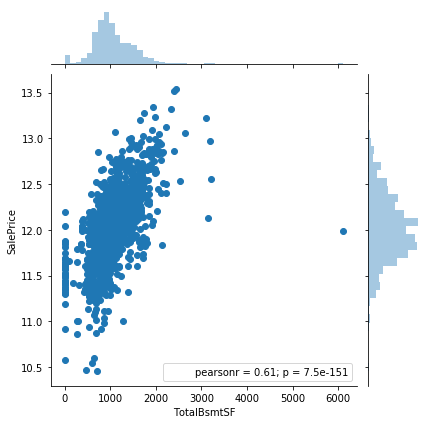

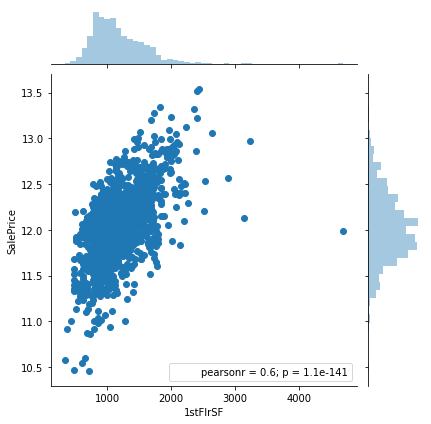

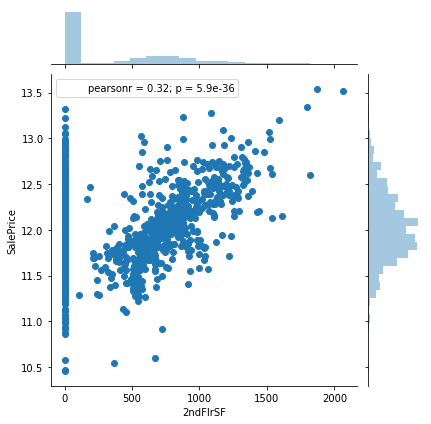

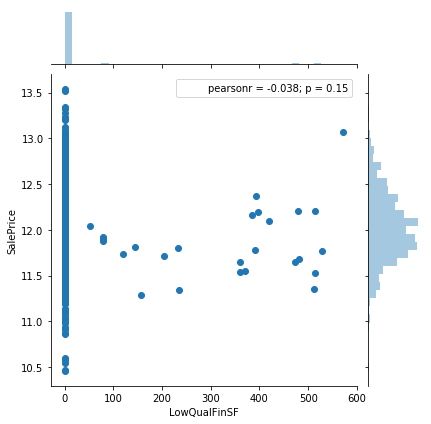

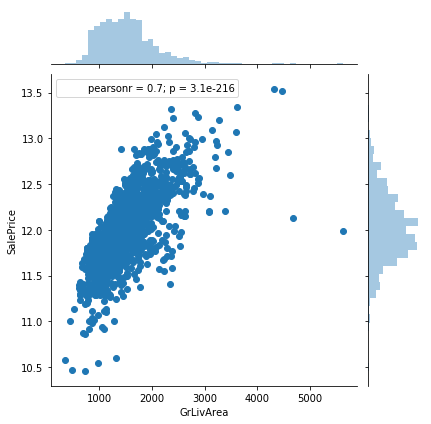

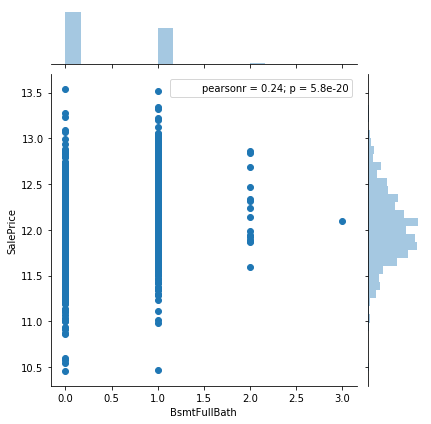

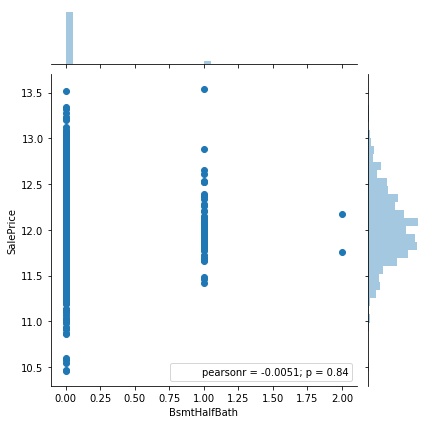

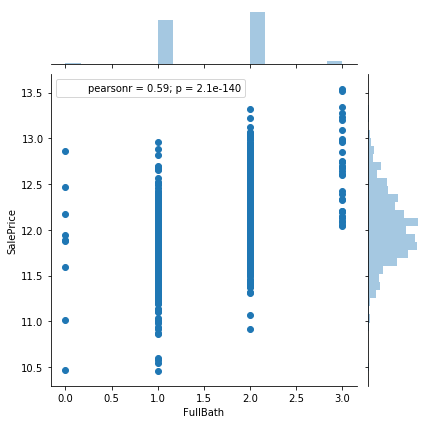

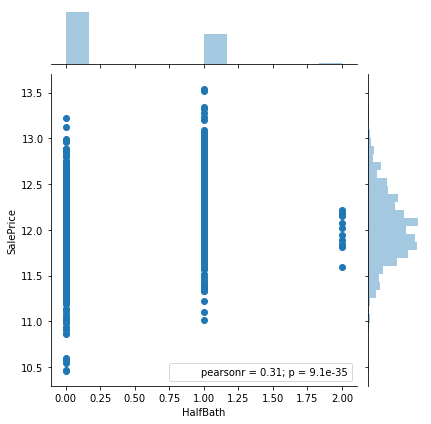

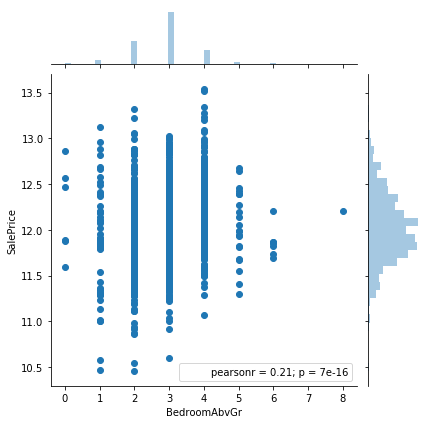

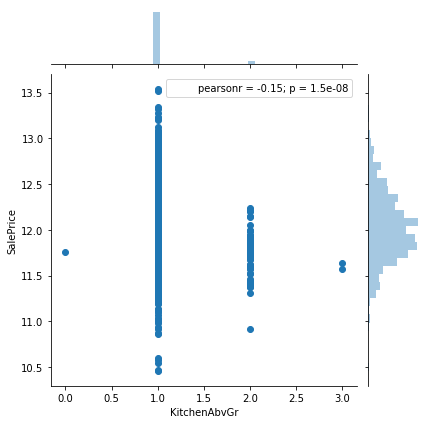

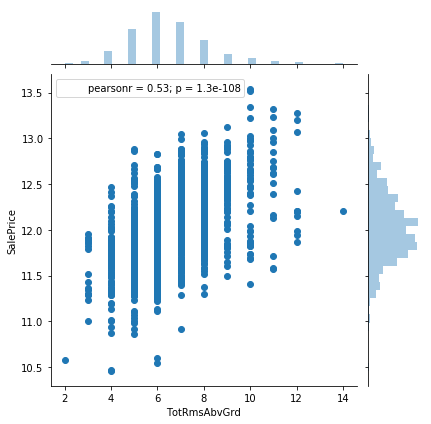

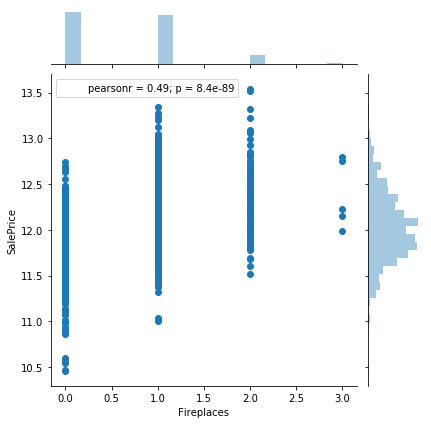

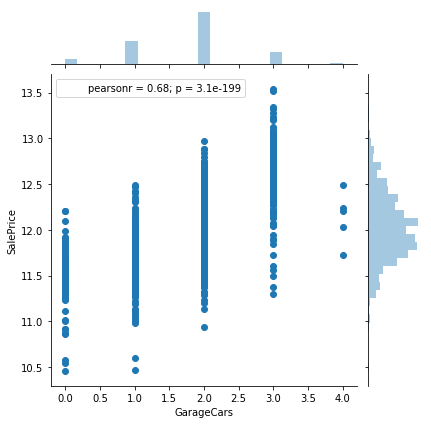

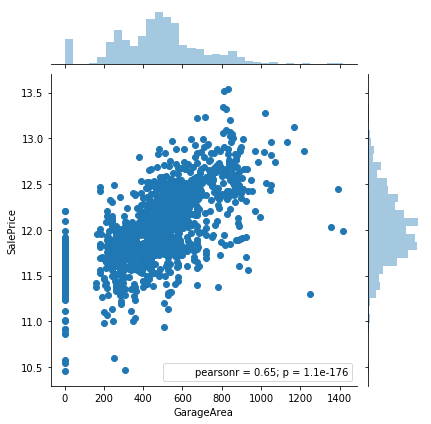

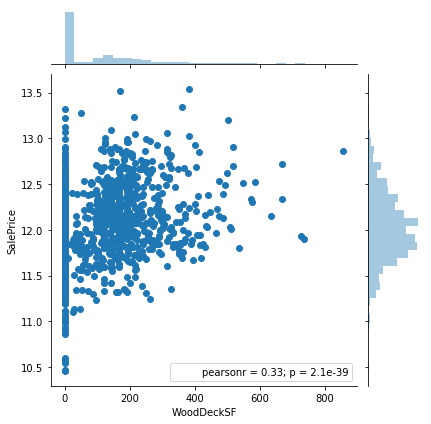

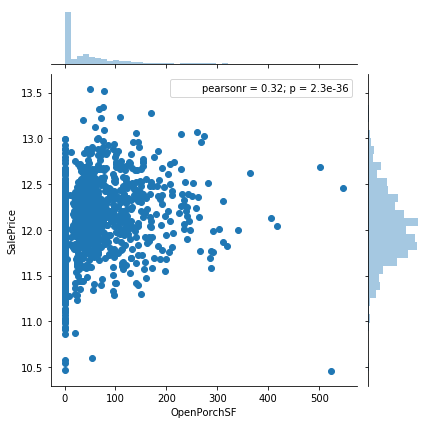

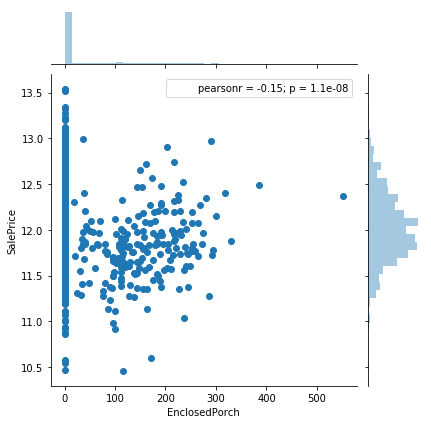

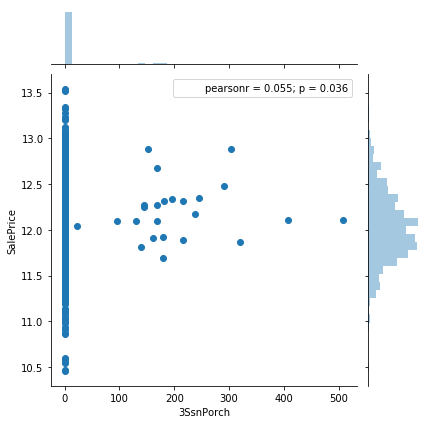

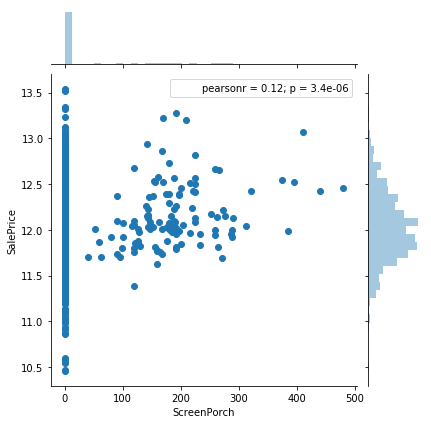

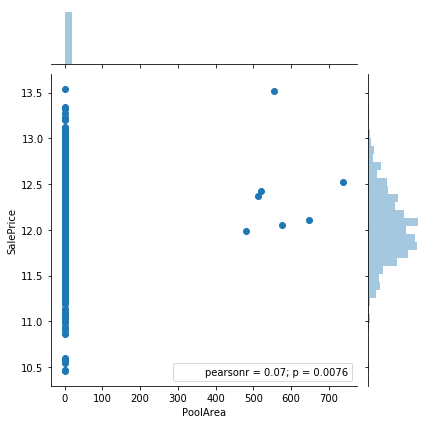

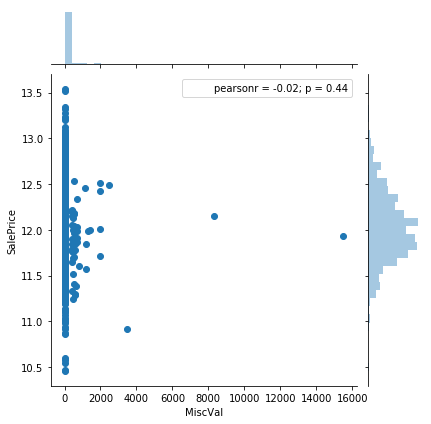

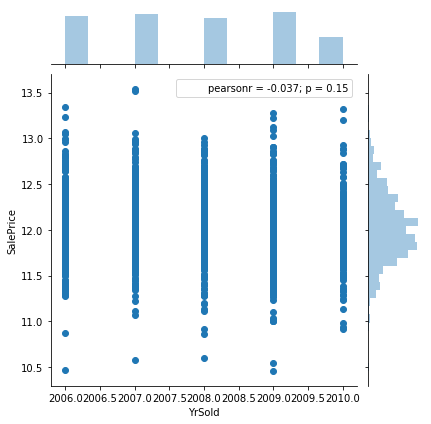

In [12]:

for var in num_variables:
    sns.jointplot( train_data[var] , np.log(train_data['SalePrice']) )
    plt.show()

### Observations from sclatter plots
1. MSSubclass is weakly correlated and seems to be very fragmented distribution - drop
2. Lot area is heavily skewed - might want to remove outliers and/or log scale
3. year variable capturing inflation
4. cont variables with a lot of zeros - 
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
5. a lot of variables might be correlated and might not be adding additional value - Basment area

In [13]:
from scipy.stats import norm

In [14]:
train_data_num.apply(lambda x : stats.skew(x.dropna())) 

LotArea          12.195142
OverallQual       0.216721
OverallCond       0.692355
YearBuilt        -0.612831
YearRemodAdd     -0.503044
MasVnrArea        2.666326
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF       1.522688
1stFlrSF          1.375342
2ndFlrSF          0.812194
LowQualFinSF      9.002080
GrLivArea         1.365156
BsmtFullBath      0.595454
BsmtHalfBath      4.099186
FullBath          0.036524
HalfBath          0.675203
BedroomAbvGr      0.211572
KitchenAbvGr      4.483784
TotRmsAbvGrd      0.675646
Fireplaces        0.648898
GarageCars       -0.342197
GarageArea        0.179796
WoodDeckSF        1.539792
OpenPorchSF       2.361912
EnclosedPorch     3.086696
3SsnPorch        10.293752
ScreenPorch       4.117977
PoolArea         14.813135
MiscVal          24.451640
YrSold            0.096170
dtype: float64

In [15]:
y = train_data['SalePrice']


### Transform num variables

In [16]:

train_data_num_tran = train_data_num.transform(func = lambda x : stats.boxcox( x + 1)[0]) # fix the sekwness of continuous variables
train_data_num_tran.fillna(train_data_num_tran.mean() , inplace = True)
# Scaling of countinuous variables
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train_data_num_tran[train_data_num_tran.columns] = scaler.fit_transform(train_data_num_tran[train_data_num_tran.columns] ) 

train_data_cat = pd.get_dummies(train_data[cat_variables])
train_data_cat.fillna(0 , inplace = True)


X = pd.concat( [train_data_num_tran , train_data_cat] , axis=1 )

C:\Users\nigamd\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:901: RuntimeWarning: overflow encountered in square
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
C:\Users\nigamd\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\nigamd\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:1030: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


C:\Users\nigamd\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


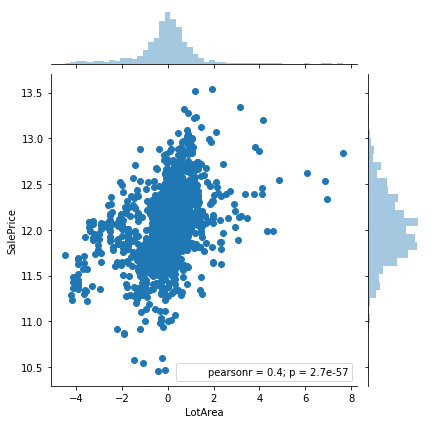

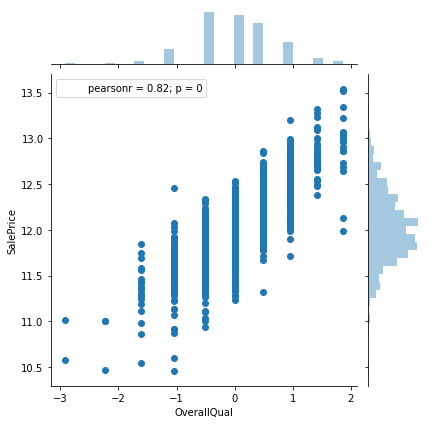

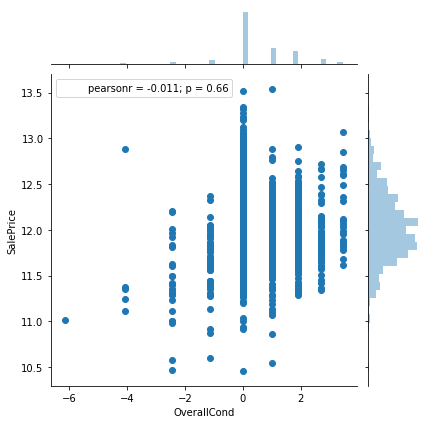

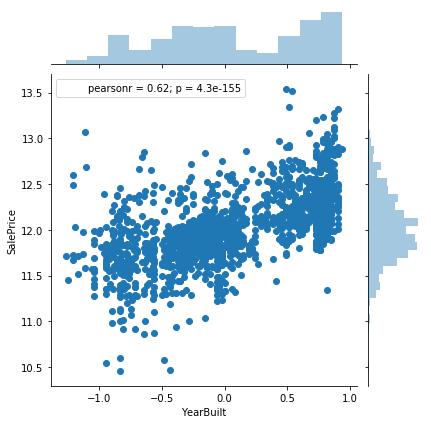

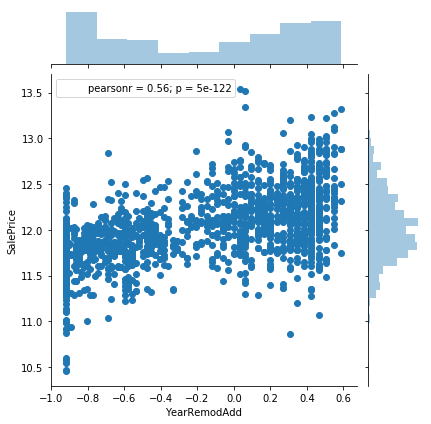

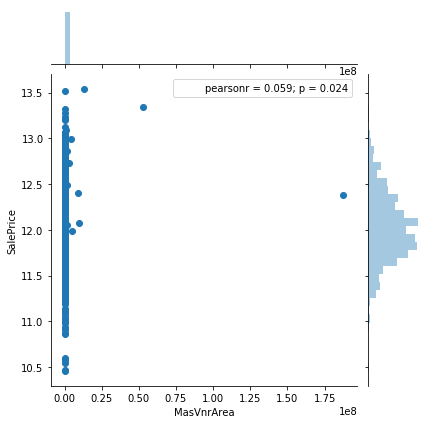

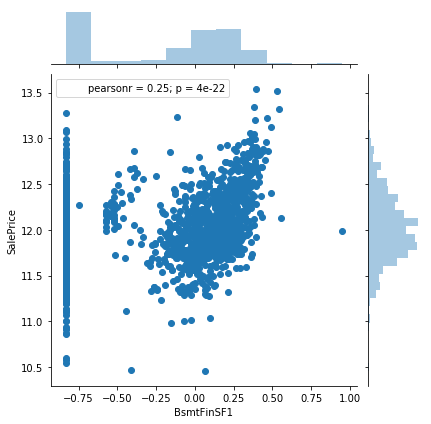

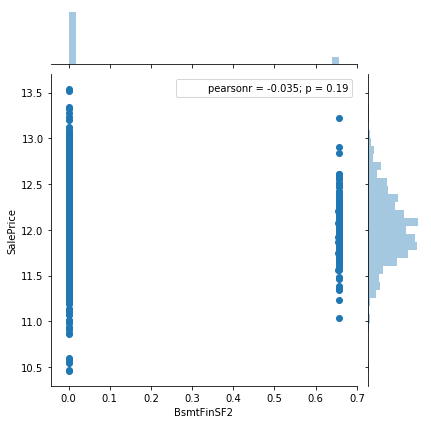

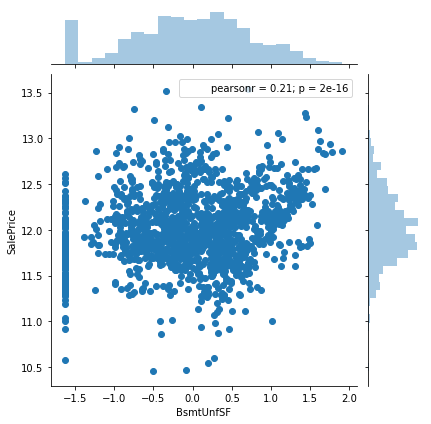

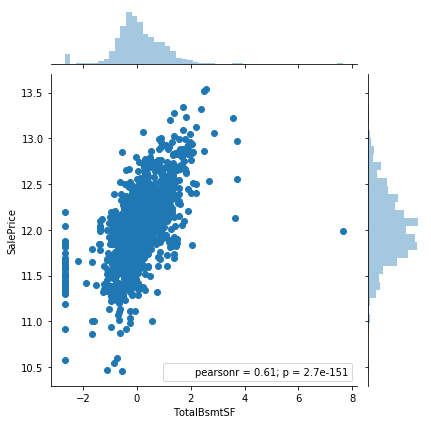

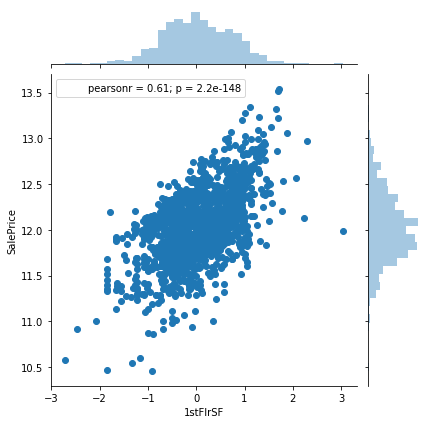

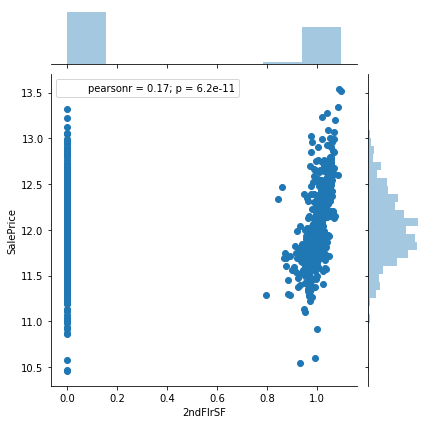

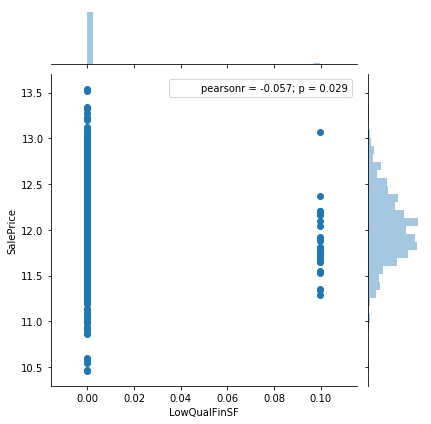

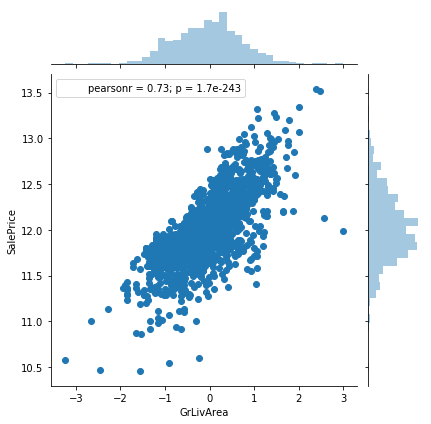

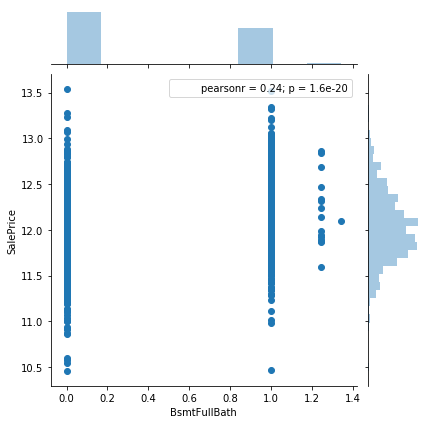

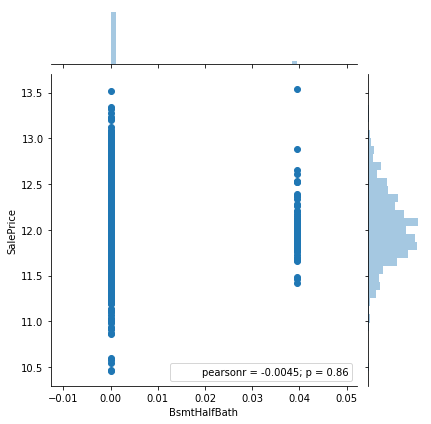

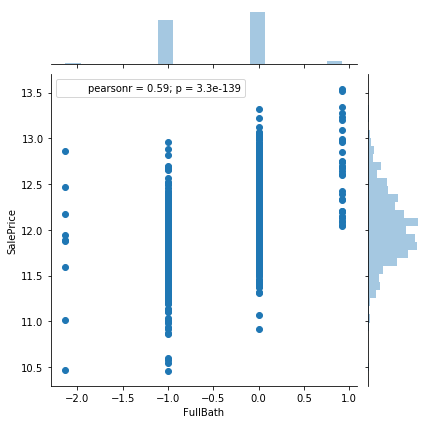

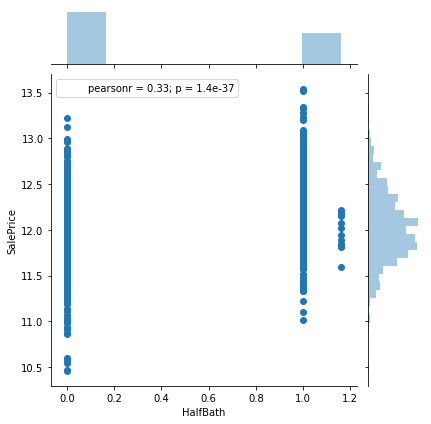

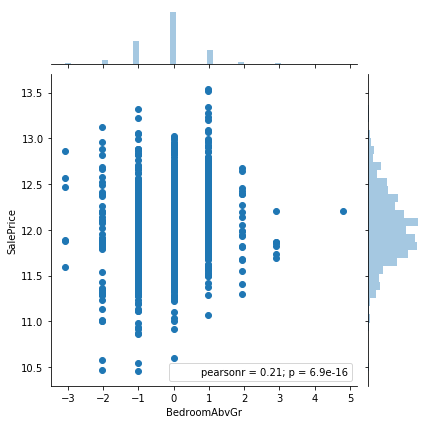

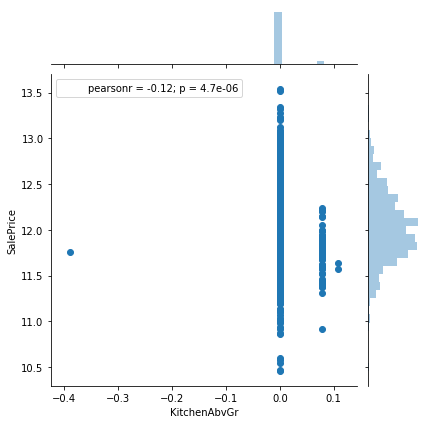

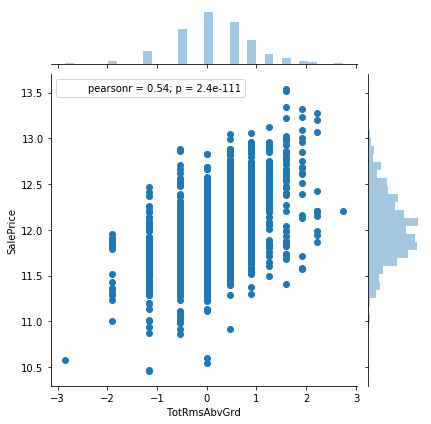

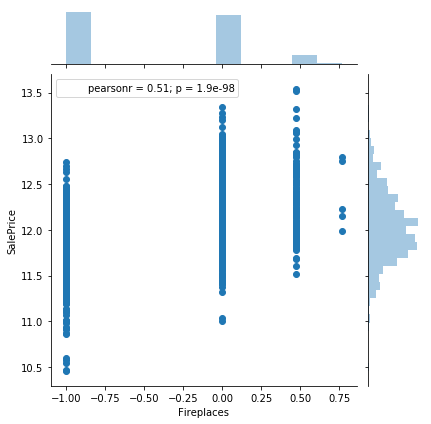

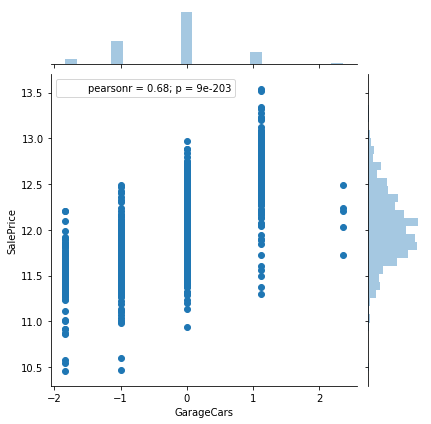

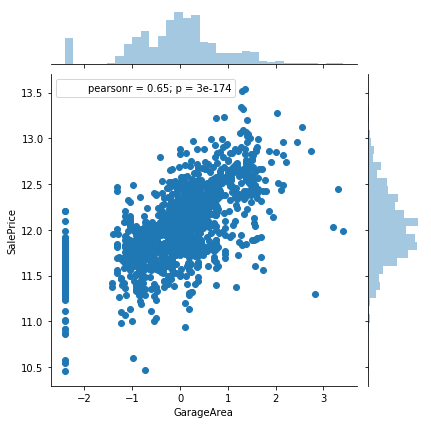

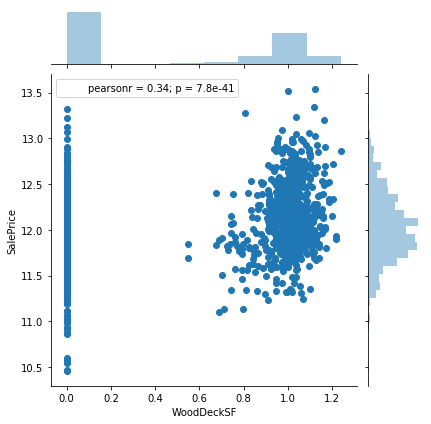

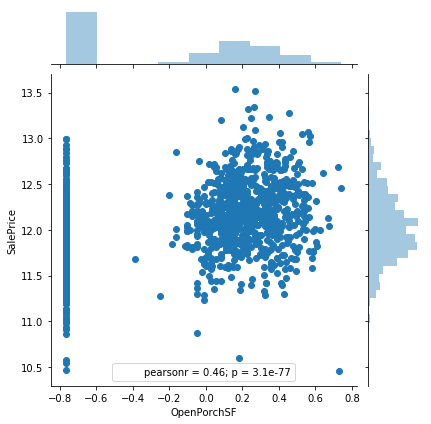

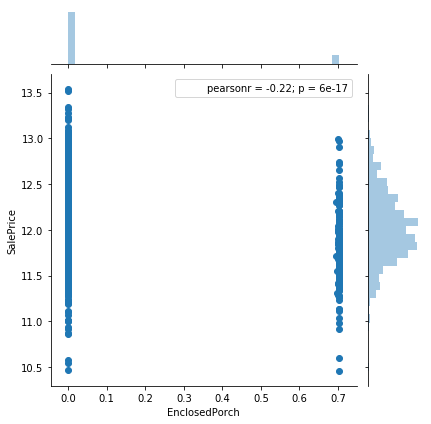

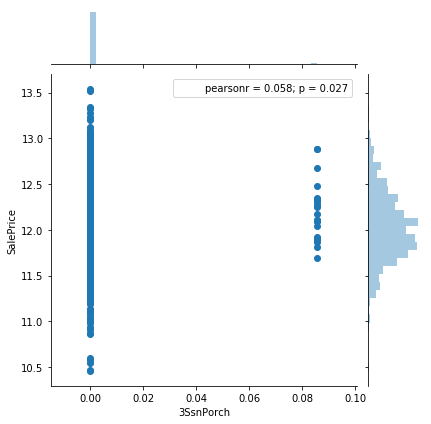

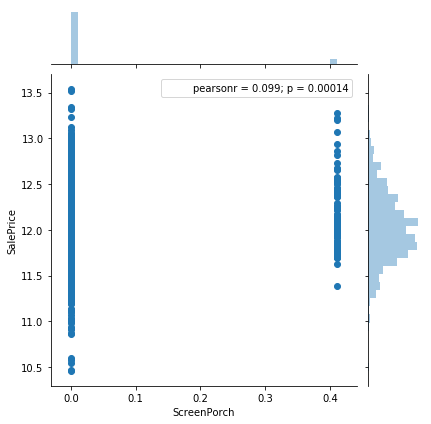

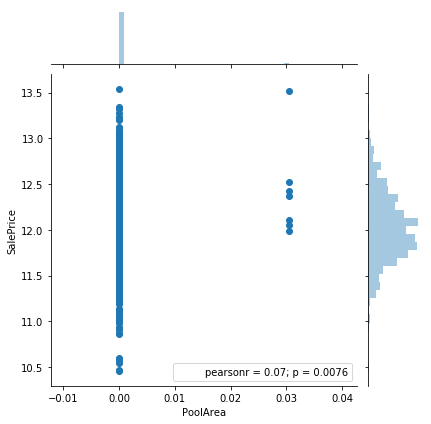

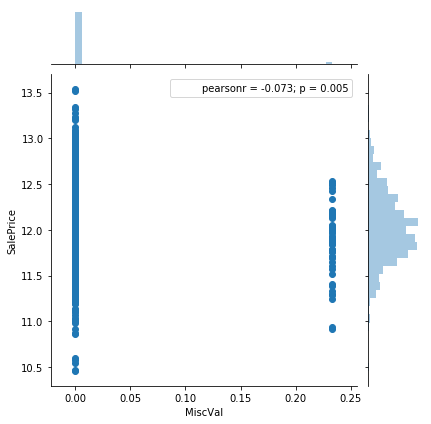

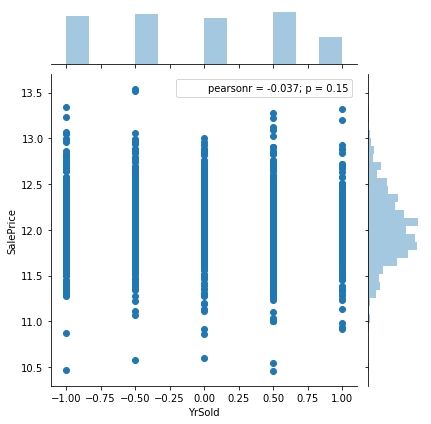

In [17]:
for var in num_variables:
    sns.jointplot( train_data_num_tran[var] , np.log(train_data['SalePrice']) )
    plt.show()

Looking at the distributions - it looks like the following variables are better modelled as (1,0) categorical fetures-
1. BsmtFinSF2
2. 2ndFlrSF
3. LowQualFinSF
4. BsmntFullBath
5. BsmtHalfBath
6. HalfBath
7. MiscVal



## Modelling

In [20]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC , LassoCV, LinearRegression ,Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler , StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
#import xgboost as xgb
#import lightgbm as lgb

In [21]:
def evaluate_model(model ,X , Y ):
    r_squared = np.mean(cross_val_score( model , X , Y ,  cv = 5 , scoring="r2"))
    rmse = np.sqrt(np.mean(-cross_val_score( model , X, Y ,  cv = 5 , scoring="neg_mean_squared_error")))
    print(f"r squared {r_squared} , rmse {rmse} " )

In [22]:
# Optial alpha for lasso

pipeline = Pipeline([
    ('lasso', Lasso())
])

parameters = {
    'lasso__alpha': (0.1,0.01, 0.001, 0.0001, 0.00001,0),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5,n_jobs=-1, verbose=1,)

grid_search.fit(X, np.log(y))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:   45.4s remaining:   59.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'lasso__alpha': (0.1, 0.01, 0.001, 0.0001, 1e-05, 0)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [23]:


modelLinReg = LinearRegression()
evaluate_model(modelLinReg , X , np.log(y))

modelLasso = Lasso(alpha = 0.001)
evaluate_model(modelLasso , X , np.log(y))
modelLasso.fit(X, np.log(y))



r squared 0.867231560342215 , rmse 0.14594712569963497 
r squared 0.8984322944593215 , rmse 0.1274971855892105 


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Lasso does significantly better than Regular regression

In [25]:
pd.DataFrame( {'variables':X.columns , 'coefs' : modelLasso.coef_}).sort_values(by = ['coefs'],ascending = False)


,variables,coefs
13,GrLivArea,0.161462
1,OverallQual,0.111007
3,YearBuilt,0.093049
78,Neighborhood_Crawfor,0.084400
94,Neighborhood_StoneBr,0.081042
...,...,...
51,MSZoning_RM,-0.037927
227,CentralAir_N,-0.043240
79,Neighborhood_Edwards,-0.051443
269,SaleCondition_Abnorml,-0.052636


In [26]:
nRejected = sum(modelLasso.coef_ == 0) / len(modelLasso.coef_)
print(f"{round(nRejected*100)} % variables eliminated by lasso")


74.0 % variables eliminated by lasso


Remarkable that almost 3/4 features were rejected by lasso and stil does better than Linear regression. Indicates that a lot of variables we collinear/ had the same information.

Lets look at what lasso retained - 


In [29]:
selected_vars = pd.DataFrame( {'variables':X.columns[modelLasso.coef_ != 0] , 'coefs' : modelLasso.coef_[modelLasso.coef_ != 0]}).sort_values(by = ['coefs'],ascending = False)

pd.concat([selected_vars.head(10), selected_vars.tail(10)] , axis=0)


,variables,coefs
9,GrLivArea,0.161462
1,OverallQual,0.111007
3,YearBuilt,0.093049
32,Neighborhood_Crawfor,0.084400
39,Neighborhood_StoneBr,0.081042
6,BsmtFinSF1,0.063952
36,Neighborhood_NridgHt,0.057789
63,Functional_Typ,0.057065
40,Condition1_Norm,0.055207
44,Exterior1st_BrkFace,0.054158


A greater living area, better overall quality and a later year all are significantly linearly and positively correlated with sale price - which makes sense.
On the other hand - an an abnormal sale condition, being in "Edward" neighbourhood and MSZoninc - class "C (all)" are all negatively correlated. Interesting to see the the most negatively correlated variables are all binary variables.

In [ ]:
# Oprimal alpha for ridge regression

pipeline = Pipeline([
    ('ridge', Ridge())
])

parameters = {
    'ridge__alpha': (1000,100,10,1,0.1,0.01, 0.001, 0.0001, 0.00001,0),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5,n_jobs=-1, verbose=1,)

grid_search.fit(X, np.log(y))

grid_search.best_params_

In [31]:
modelRidge = Ridge(alpha = 10)
evaluate_model(modelRidge , X , np.log(y))
modelRidge.fit(X, np.log(y))

r squared 0.8933354278278738 , rmse 0.13058124674261112 


Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [32]:
nRejected = sum(modelRidge.coef_ == 0) / len(modelRidge.coef_)
print(f"{round(nRejected*100)} % variables eliminated by ridge")


0.0 % variables eliminated by ridge


Was stupid of me to see how many variable ridge reject since ridge penalty does not result in zero coefficients like lasso. 

In [ ]:
# Oprimal alpha for ridge regression

pipeline = Pipeline([
    ('elasticnet', ElasticNet())
])

parameters = {
    'elasticnet__alpha': [1000,100,10,1,0.1,0.01, 0.001, 0.0001, 0.00001,0],
    'elasticnet__l1_ratio': (1,0.50 , 0.1,0.01 ,0)
}

grid_search = GridSearchCV(pipeline, parameters, cv=5,n_jobs=-1, verbose=1,)

grid_search.fit(X, np.log(y))

grid_search.best_params_

In [33]:

modelElastic = ElasticNet(alpha = 0.001 , l1_ratio=0.5)
evaluate_model(modelElastic , X , np.log(y))
modelElastic.fit(X, np.log(y))


r squared 0.9005328372643122 , rmse 0.1261019097063763 


ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
nRejected = sum(modelElastic.coef_ == 0) / len(modelElastic.coef_)
print(f"{round(nRejected*100)} % variables eliminated by elastic")

60.0 % variables eliminated by elastic


Elastic net has a better performance. It eleminates fewer variables than lasso. 

In [35]:
## PCA followed by regresion
pca = PCA()
pca.fit_transform(X)
sns.lineplot( list(range(0,10,1)),pca.explained_variance_ratio_[0:10] )


AttributeError: module 'seaborn' has no attribute 'lineplot'

It is super interesting that almost all the variation in the data has been explaned by just 1 feature. This is a strange. 
Turns out it is because the PCA does not scale the data. We may have data with very different stdev in the inupt features since we hav only scaled using IQR.


In [37]:
scaler2 = StandardScaler()
X_hat = X
X_hat[X_hat.columns] = scaler2.fit_transform(X_hat)

In [38]:
pca = PCA()
X_pca = pca.fit_transform(X_hat)
sns.lineplot( list(range(0,10,1)),pca.explained_variance_ratio_[0:10] )

AttributeError: module 'seaborn' has no attribute 'lineplot'

In [39]:
sns.lineplot( range(X.shape[1]), np.cumsum(pca.explained_variance_ratio_))

AttributeError: module 'seaborn' has no attribute 'lineplot'

In [40]:
X_pca[:,:100].shape

(1460, 100)

In [41]:
evaluate_model(modelLasso , X_pca[:,:100], np.log(y))

r squared 0.8639519306221917 , rmse 0.1470567839956611 


It doesnt look like PCA is able to reduce the dimensions drastically. To explain 50% of the variation - we do need around 50 variables - further cross validation on any meaningful subset does not improve performance over lasso/ridge.

In [43]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor(max_depth=3)

evaluate_model(dec_tree , X ,  np.log(y))
dec_tree.fit(X ,  np.log(y))

r squared 0.6696159332575442 , rmse 0.2288229090803873 


DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Although a single decision tree does not do a stellar job at preditions, it is a good way to see what factors it deems most important. LEts find out in the below code.

In [44]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    alpha = ", ".join(feature_names)
    print ("def tree(" , alpha,"):")

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print (f"{indent}if {name} <= {threshold}:")
            recurse(tree_.children_left[node], depth + 1)
            print (f"{indent}else:  # if {name} > {threshold}")
            recurse(tree_.children_right[node], depth + 1)
        else:
            print (f"{indent}return {tree_.value[node]}")

    recurse(0, 1)

In [45]:

pipeline = Pipeline([
    ('dec_tree', DecisionTreeRegressor())
])


parameters = {
    'dec_tree__max_depth': list(range(1,21,1)) ,
}

grid_search = GridSearchCV(pipeline, parameters, cv=5,n_jobs=-1, verbose=1,)

grid_search.fit(X, np.log(y))

grid_search.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


{'dec_tree__max_depth': 6}

In [46]:
grid_search.cv_results_['mean_test_score']
grid_search.param_grid['dec_tree__max_depth']

sns.lineplot( grid_search.param_grid['dec_tree__max_depth'], grid_search.cv_results_['mean_test_score'])


AttributeError: module 'seaborn' has no attribute 'lineplot'

75% of the variance is explained by 5 levels of depth with marginal or no improvements by adding further depth.

Although the model itself does not perform as well as others, it does . give some insight into feature importance if we closely look at the tree structure using the tree_to_ code function above. Although I do not sho

In [47]:
dec_tree = DecisionTreeRegressor(max_depth=5)

evaluate_model(dec_tree , X ,  np.log(y))
dec_tree.fit(X ,  np.log(y))
tree_to_code(dec_tree, X.columns)

r squared 0.7428167568042314 , rmse 0.20211054899658026 
def tree( LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, YrSold, MSSubClass_120, MSSubClass_160, MSSubClass_180, MSSubClass_190, MSSubClass_20, MSSubClass_30, MSSubClass_40, MSSubClass_45, MSSubClass_50, MSSubClass_60, MSSubClass_70, MSSubClass_75, MSSubClass_80, MSSubClass_85, MSSubClass_90, MSZoning_C (all), MSZoning_FV, MSZoning_RH, MSZoning_RL, MSZoning_RM, Street_Grvl, Street_Pave, LotShape_IR1, LotShape_IR2, LotShape_IR3, LotShape_Reg, LandContour_Bnk, LandContour_HLS, LandContour_Low, LandContour_Lvl, Utilities_AllPub, Utilities_NoSeWa, LotConfig_Corner, LotConfig_CulDSac, LotConfig_FR2, LotConfig_FR3,

Although it is not easy to interpret the tree as a whole - galcing across the first few levels tells us what the most important factors for the decision tree are - OverallQual, GrLivArea, TotalBsmtSF

In [60]:
ran_forest = RandomForestRegressor(n_estimators=50 , criterion="mse" ,max_depth=5,max_features=100)
ran_forest.fit(X ,np.log(y))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=100, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [61]:
evaluate_model(ran_forest , X ,  np.log(y))

r squared 0.8453593242947643 , rmse 0.1588451707245337 
